In [ ]:
!pip install torch torchvision torchtext scikit-learn pandas numpy scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
pip install torch transformers pandas scikit-learn


In [ ]:
# 📌 Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 📌 Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Load Dataset
df = pd.read_excel("1-LG-1-LN-SF9.xlsx")

# Convert Interference_Label to Binary Classification
df["Interference_Label"] = ((df["RSSI"] < -90) & (df["SNR"] < 5)).astype(int)

# 📌 Initialize DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize Messages
tokens = tokenizer(df["Message"].tolist(), padding=True, truncation=True, return_tensors="pt")

# 📌 Extract Numerical Features (RSSI, SNR) & Normalize
scaler = MinMaxScaler()
tabular_features = scaler.fit_transform(df[["RSSI", "SNR"]].values)
tabular_features = torch.tensor(tabular_features, dtype=torch.float32)

# 📌 Prepare Labels
labels = torch.tensor(df["Interference_Label"].values, dtype=torch.float32)

# 📌 Split into Train & Test
(train_ids, test_ids,
 train_masks, test_masks,
 train_tabular, test_tabular,
 train_labels, test_labels) = train_test_split(
    tokens["input_ids"], tokens["attention_mask"],
    tabular_features, labels, test_size=0.2, random_state=42
)

# 📌 Define Dataset Class
class InterferenceDataset(Dataset):
    def __init__(self, input_ids, attention_masks, tabular_features, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.tabular_features = tabular_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "tab_input": self.tabular_features[idx],
            "label": self.labels[idx]
        }

# 📌 Create DataLoaders
batch_size = 16

train_dataset = InterferenceDataset(train_ids, train_masks, train_tabular, train_labels)
test_dataset = InterferenceDataset(test_ids, test_masks, test_tabular, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 📌 Define CNN + LSTM Model with DistilBERT
class CNN_LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 2 + 2, 64)  # LSTM output + tabular data
        self.fc2 = nn.Linear(64, 1)

    def forward(self, input_ids, attention_mask, tab_input):
        # DistilBERT Text Embedding
        bert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = bert_output.last_hidden_state  # Shape: (batch, seq_len, 768)

        # CNN Feature Extraction
        text_embedding = text_embedding.permute(0, 2, 1)  # Change shape to (batch, channels, seq_len)
        text_embedding = self.pool(torch.relu(self.conv1(text_embedding)))
        text_embedding = self.pool(torch.relu(self.conv2(text_embedding)))

        # LSTM Processing
        text_embedding = text_embedding.permute(0, 2, 1)  # Back to (batch, seq_len, channels)
        lstm_out, _ = self.lstm(text_embedding)
        lstm_out = lstm_out[:, -1, :]  # Get last time step output

        # Combine LSTM output with Tabular Data
        combined_features = torch.cat((lstm_out, tab_input), dim=1)

        # Fully Connected Layers
        x = torch.relu(self.fc1(combined_features))
        x = torch.sigmoid(self.fc2(x))  # Binary classification

        return x

# 📌 Initialize Model, Optimizer, and Loss Function
model = CNN_LSTM_Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()

# 📌 Training Loop
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        tab_input = batch["tab_input"].to(device)
        labels = batch["label"].to(device).unsqueeze(1)  # Ensure correct shape

        # Forward pass
        outputs = model(input_ids, attention_mask, tab_input)
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# 📌 Save Model
torch.save(model.state_dict(), "cnn_lstm_interference_model.pth")

# 📌 Evaluation Function
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            tab_input = batch["tab_input"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            outputs = model(input_ids, attention_mask, tab_input)
            predictions = (outputs > 0.5).float()

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

# 📌 Test the Model
accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1, Loss: 0.3336537622511387


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Interference", "Interference"],
                yticklabels=["No Interference", "Interference"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function after getting predictions
plot_confusion_matrix(all_labels, all_preds)


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, probabilities):
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

# Call the function after getting probabilities
plot_roc_curve(all_labels, all_probs)


In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(true_labels, probabilities):
    precision, recall, _ = precision_recall_curve(true_labels, probabilities)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="green", label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# Call the function after getting probabilities
plot_precision_recall_curve(all_labels, all_probs)


In [ ]:
## Model 2 Random Forest CLassifier

In [ ]:
import random
import pandas as pd

def generate_sample_data(n=1000):
    data = []
    for _ in range(n):
        distance = random.uniform(50, 1000)  # in meters
        interference = random.choice(['Low', 'Medium', 'High'])
        # Simulate optimal SF (this can be replaced with actual values or a rule-based labeler)
        if interference == 'High':
            sf = 12 if distance > 500 else 11
        elif interference == 'Medium':
            sf = 10 if distance > 400 else 9
        else:
            sf = 7 if distance < 400 else 8

        data.append({'distance': distance, 'interference': interference, 'sf': sf})

    return pd.DataFrame(data)

df = generate_sample_data()


In [ ]:
import pandas as pd
import random

# Generate the realistic dataset
def generate_realistic_lora_dataset(n=2000):
    data = []

    for i in range(n):
        msg_id = f"MSG_{i+1}"

        # Simulate RSSI (dBm)
        rssi = random.uniform(-120, -30)

        # Simulate SNR based on RSSI
        if rssi > -85:
            snr = random.uniform(0, 10)
        elif rssi > -100:
            snr = random.uniform(-5, 5)
        elif rssi > -110:
            snr = random.uniform(-10, 3)
        else:
            snr = random.uniform(-20, 0)

        # SF Assignment (based on real-world decoding thresholds)
        if snr >= -7.5 and rssi >= -90:
            sf = 7
        elif snr >= -10 and rssi >= -95:
            sf = 8
        elif snr >= -12.5 and rssi >= -100:
            sf = 9
        elif snr >= -15 and rssi >= -110:
            sf = 10
        elif snr >= -17.5:
            sf = 11
        else:
            sf = 12

        data.append({
            "Message": msg_id,
            "RSSI": round(rssi, 2),
            "SNR": round(snr, 2),
            "SF": sf
        })

    return pd.DataFrame(data)

# Generate the dataset
df = generate_realistic_lora_dataset()

# Save to Excel
excel_filename = "lora_sf_dataset.xlsx"
df.to_excel(excel_filename, index=False)

# Display download link
from google.colab import files
files.download(excel_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load the Excel file if needed
df = pd.read_excel("/content/lora_sf_dataset.xlsx")

# Preview
df.head()


,Message,RSSI,SNR,SF
0,MSG_1,-75.82,8.16,7
1,MSG_2,-108.61,-1.40,10
2,MSG_3,-117.08,-8.02,11
3,MSG_4,-76.28,1.76,7
4,MSG_5,-94.49,4.92,8


In [ ]:
from sklearn.model_selection import train_test_split

X = df[['RSSI', 'SNR']]
y = df['SF']

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           7       1.00      1.00      1.00       247
           8       1.00      0.97      0.98        32
           9       0.96      1.00      0.98        23
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        43
          12       1.00      1.00      1.00         4

    accuracy                           1.00       400
   macro avg       0.99      0.99      0.99       400
weighted avg       1.00      1.00      1.00       400



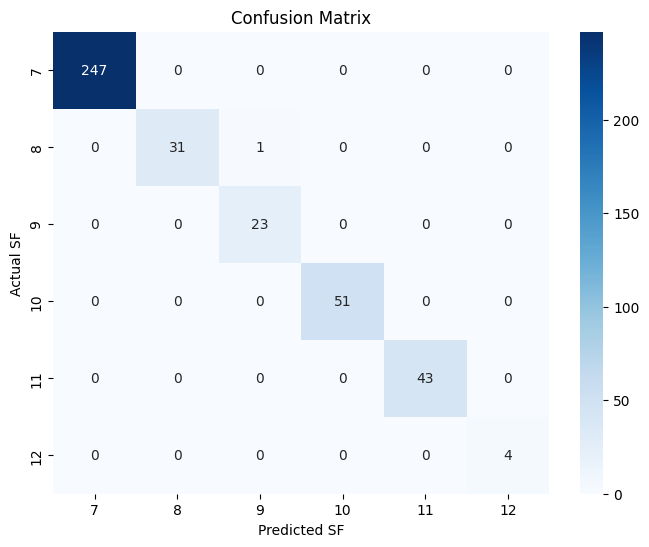

In [ ]:
# STEP 4: Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted SF")
plt.ylabel("Actual SF")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# STEP 5: Define zone assignment logic (based on SF)
def assign_interference_zone(predicted_sf):
    return "High Interference Zone" if predicted_sf >= 10 else "Low Interference Zone"


In [ ]:
# STEP 6: Predict SF + assign zone for new values
def predict_sf_and_zone(rssi, snr):
    predicted_sf = model.predict([[rssi, snr]])[0]
    zone = assign_interference_zone(predicted_sf)
    print(f"RSSI = {rssi} dBm | SNR = {snr} dB")
    print(f"→ Predicted SF: SF{predicted_sf}")
    print(f"→ Assigned Zone: {zone}")
    return predicted_sf, zone

# Test examples
predict_sf_and_zone(-92, -6.5)
predict_sf_and_zone(-75, 5.0)
predict_sf_and_zone(-110, -15.0)


RSSI = -92 dBm | SNR = -6.5 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -75 dBm | SNR = 5.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -110 dBm | SNR = -15.0 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(np.int64(11), 'High Interference Zone')

In [ ]:
# STEP 7 (Optional): Apply zone logic to test set and save results
sf_preds = model.predict(X_test)
interference_zones = [assign_interference_zone(sf) for sf in sf_preds]

results_df = X_test.copy()
results_df['Predicted_SF'] = sf_preds
results_df['Zone'] = interference_zones

# Export to Excel (optional)
results_df.to_excel("sf_zone_results.xlsx", index=False)

# Download in Colab
from google.colab import files
files.download("sf_zone_results.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

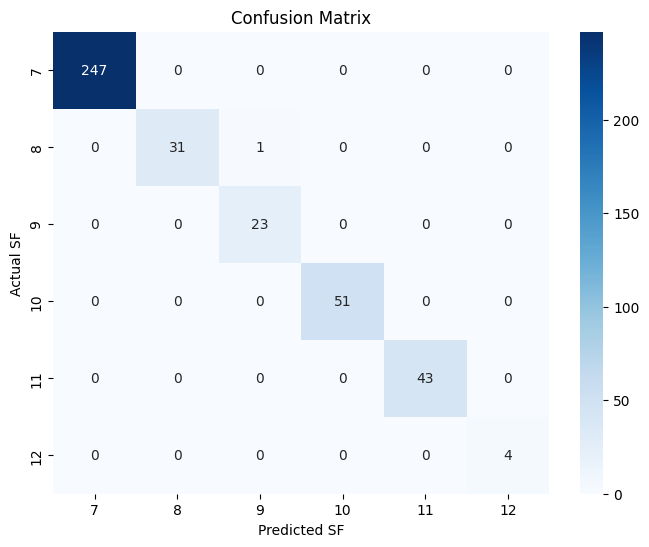

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted SF")
plt.ylabel("Actual SF")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-15-9fcd605a3af9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


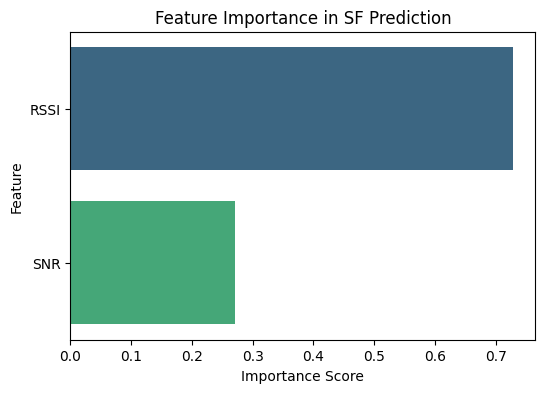

In [ ]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=features, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in SF Prediction")
plt.show()


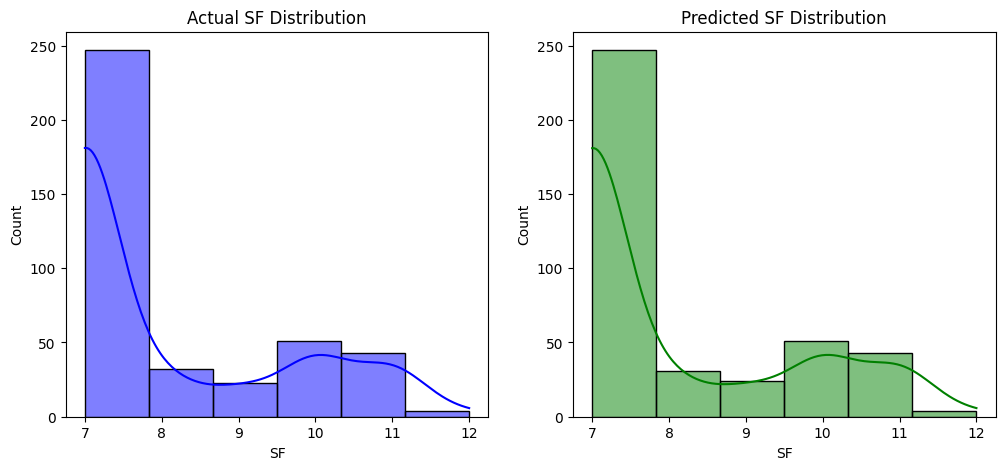

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Actual SF Distribution
sns.histplot(y_test, bins=6, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Actual SF Distribution")
axes[0].set_xlabel("SF")

# Predicted SF Distribution
sns.histplot(y_pred, bins=6, kde=True, color="green", ax=axes[1])
axes[1].set_title("Predicted SF Distribution")
axes[1].set_xlabel("SF")

plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -120.0 dBm | SNR = -20.0 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -120.0 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -120.0 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -120.0 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -120.0 dBm | SNR = 6.9387755

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -118.16326530612245 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -118.1632653

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -118.16326530612245 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -118.16326530612245 dBm | SNR = 7.55

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -116.3265306122449 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -116.3265306122449 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -116.3265306122449 dB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -116.3265306122449 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -116.3265306122449 dBm | SNR = 8.16326530612245

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -114.48979591836735 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.489795918

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -114.48979591836735 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.48979591836735 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -114.489795

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -114.48979591836735 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -114.48979591836735 dBm | SNR = 10.0 dB
→

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -112.65306122448979 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.653061

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -112.65306122448979 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122448979 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -112.65306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -112.65306122448979 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -112.65306122448979 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -112.65306122448979 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -112.65306122448979 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -112.65306122448979 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -112.65306122448979 dBm | SNR = 10.0 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -20.0 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -18.775510204081634 dB
→ Pre

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -110.81632653061224 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.816326530

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -110.81632653061224 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF11
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -110.81632653061224 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -110.81632653061224 dBm

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -108.9795918367347 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -108.9795918367347 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -108.9795918367347 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -108.9795918367347 dBm | SNR 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -107.14285714285714 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -107.14285714285714 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.142857

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -107.14285714285714 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -107.14285714285714 d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -105.3061224489796 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -105.3061224489796 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm |

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -105.3061224489796 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -105.3061224489796 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -105.3061224489796 dBm | SNR = 10.0 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -20.0 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -17.551020408163

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -103.46938775510205 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.469387

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -103.46938775510205 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.469387

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -103.46938775510205 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -103.46938775510205 dBm |

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -101.63265306122449 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -101.63265306122449 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.632653

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -101.63265306122449 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -101.63265306122449 dBm | 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -99.79591836734694 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -99.79591836734694 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -99.79591836734694 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -99.79591836734694 dBm | SNR = 9.387755102040817 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -97.95918367346938 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -12.040

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -97.95918367346938 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = -1.6

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -97.95918367346938 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 7.5510204081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -97.95918367346938 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -97.95918367346938 dBm | SNR = 10.0 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -20.0 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -17.551020408163264 dB
→ Pred

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -96.12244897959184 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -96.12244897959184 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -96.12244897959184 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RSSI = -96.12244897959184 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RSSI = -96.12244897959184 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RSSI = -96.12244897959184 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 4.4897959183

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -96.12244897959184 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -96.12244897959184 dBm | SNR = 10.0 dB
→ Predicted SF: SF9
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -20.0 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -16.3265306122449 dB
→

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -94.28571428571428 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -94.28571428571428 dBm 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -94.28571428571428 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 3.8775510204

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -94.28571428571428 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -94.28571428571428 dBm | SNR = 10.0 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -20.0 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF12
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -16.93877551020408 dB
→ P

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -92.44897959183673 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -92.44897959183673 dBm |

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -92.44897959183673 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -92.44897959183673 dBm | SNR = 5.10204081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -90.61224489795919 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF10
→ Assigned Zone: High Interference Zone
RSSI = -90.61224489795919 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -90.61224489795919 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF8
→ Assigned Zone: Low Interference Zone
RSSI = -90.61224489795919 dBm | SNR = 7.5510204081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -88.77551020408163 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = -5.306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -88.77551020408163 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -88.77551020408163 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -17.551020408163264 dB
→ Predicted SF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -86.93877551020408 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -86.93877551020408 dBm | SNR = -0.40

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -85.10204081632654 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -13.26

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -85.10204081632654 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -85.10204081632654 dBm | SNR = 3.8775510204

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -83.26530612244898 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = -7.755

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -83.26530612244898 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -83.26530612244898 dBm | SNR = 10.0 dB
→ Predicte

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -81.42857142857143 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = -7.1428

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -81.42857142857143 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -81.42857142857143 dBm | SNR = 8.775510204081634

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -79.59183673469389 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = -2.857

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -79.59183673469389 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -79.59183673469389 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -16.3265306122449 dB
→ Predicted S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -77.75510204081633 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -77.75510204081633 dBm | SNR = -0.40

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -75.91836734693877 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -15.10204081632653 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -75.91836734693877 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -75.91836734693877 dBm | SNR = 2.04081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -74.08163265306122 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = -10.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -74.08163265306122 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -74.08163265306122 dBm | SNR = 7.5510204081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -72.24489795918367 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = -7.1428

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -72.24489795918367 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -72.24489795918367 dBm | SNR = 8.16326530612245

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -70.40816326530611 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = -5.306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -70.40816326530611 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -70.40816326530611 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -68.57142857142857 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = -3.46938

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -68.57142857142857 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -68.57142857142857 dBm | SNR = 10.0 dB
→ Predicte

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -66.73469387755102 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = -4.08163

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -66.73469387755102 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -66.73469387755102 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -64.89795918367346 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -64.89795918367346 dBm | SNR = -1.6

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -63.06122448979592 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -14.48

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -63.06122448979592 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = -2.24

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -63.06122448979592 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -63.06122448979592 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -16.3265306122449 dB
→ Pred

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -61.224489795918366 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -61.224489795918366 dBm | SNR = 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -59.38775510204081 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = -12.653

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -59.38775510204081 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -59.38775510204081 dBm | SNR = 5.10204081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -57.55102040816326 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = -10.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -57.55102040816326 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -57.55102040816326 dBm | SNR = 8.775510204081634

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -55.71428571428571 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = -5.306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -55.71428571428571 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -55.71428571428571 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -53.87755102040816 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = -5.306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -53.87755102040816 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -53.87755102040816 dBm | SNR = 9.387755102040817 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -52.04081632653062 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = -5.306122

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -52.04081632653062 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -52.04081632653062 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -16.93877551020408 dB
→ Predicted S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -50.20408163265306 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -50.20408163265306 dBm | SNR = 0.2040

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -48.36734693877551 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = -12.040

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -48.36734693877551 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -48.36734693877551 dBm | SNR = 5.71428571428

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -46.53061224489795 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = -7.755

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -46.53061224489795 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -46.53061224489795 dBm | SNR = 6.32653061224

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -44.69387755102041 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -13.87

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -44.69387755102041 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = -4.08163

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -44.69387755102041 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -44.69387755102041 dBm | SNR = 8.16326530612245

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -42.85714285714286 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -11.428571428571429 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -10.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -42.85714285714286 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 2.04081632

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -42.85714285714286 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -42.85714285714286 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -41.0204081632653 dBm | SNR = -10.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -10.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -9.591836734693878 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -8.979591836734693 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -8.36734693877551 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = -5.918367346938774

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -41.0204081632653 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 3.8775510204081627 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 4.489795918367349 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -41.0204081632653 dBm | SNR = 6.938775510204081 dB
→ 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -39.183673469387756 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -39.183673469387756 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -39.183673469387756 dBm | SNR = 5.102040816326532 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -39.183673469387756 dBm | SNR = 10.0 dB
→

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -37.346938775510196 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -13.877551020408163 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -13.26530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -12.653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -12.040816326530612 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -37.346938775510196 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SN

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -37.346938775510196 dBm | SNR = 5.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 6.326530612244898 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 6.938775510204081 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 7.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 8.163265306122451 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 8.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -37.346938775510196 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -20.0 dB
→ Predicted SF

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -35.51020408163265 dBm | SNR = -7.755102040816325 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -7.142857142857142 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -6.530612244897959 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -5.9183673469387745 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = -2.857

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -35.51020408163265 dBm | SNR = 9.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -35.51020408163265 dBm | SNR = 10.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -20.0 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -16.3265306122449 dB
→ Pred

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -33.673469387755105 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -33.673469387755105 dBm | SN

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -31.836734693877546 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -31.836734693877546 dBm | SNR = -5.3061224489795915 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -4.6938775510204085 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -4.081632653061224 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -3.4693877551020407 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -2.8571428571428577 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -2.2448979591836746 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -31.836734693877546 dBm | SN

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -30.0 dBm | SNR = -19.387755102040817 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -18.775510204081634 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -18.163265306122447 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -17.551020408163264 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -16.93877551020408 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -16.3265306122449 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -15.714285714285715 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -15.10204081632653 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -14.489795918367346 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -13.877551020408

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

RSSI = -30.0 dBm | SNR = -1.632653061224488 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -1.020408163265305 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = -0.408163265306122 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 0.204081632653061 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 0.816326530612244 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 1.4285714285714306 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 2.0408163265306136 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 2.6530612244897966 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 3.2653061224489797 dB
→ Predicted SF: SF7
→ Assigned Zone: Low Interference Zone
RSSI = -30.0 dBm | SNR = 3.8775510204081627 dB
→

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

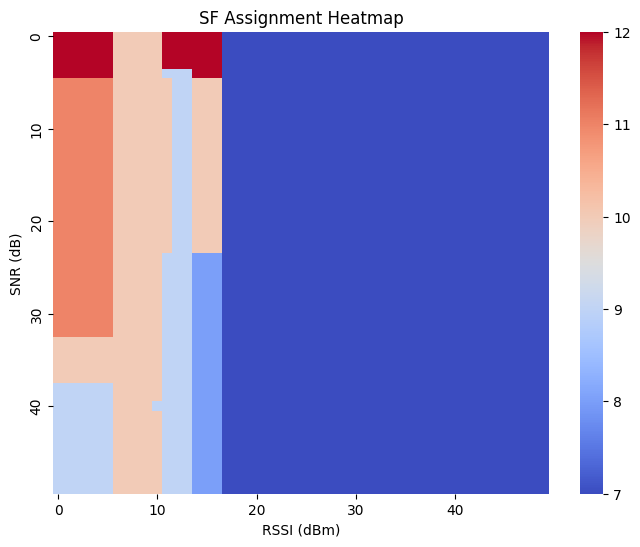

In [ ]:
import numpy as np

# Create a grid of RSSI and SNR values
rssi_vals = np.linspace(-120, -30, 50)
snr_vals = np.linspace(-20, 10, 50)
heatmap_data = np.zeros((50, 50))

# Predict SF for each (RSSI, SNR) pair
for i, rssi in enumerate(rssi_vals):
    for j, snr in enumerate(snr_vals):
        sf_pred, _ = predict_sf_and_zone(rssi, snr)
        heatmap_data[j, i] = sf_pred

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, xticklabels=10, yticklabels=10, cmap="coolwarm", cbar=True)
plt.xlabel("RSSI (dBm)")
plt.ylabel("SNR (dB)")
plt.title("SF Assignment Heatmap")
plt.show()


In [ ]:
# MODEL 3 Reinforcement learning

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict


In [ ]:
# Define discrete bins for RSSI and SNR
rssi_bins = np.linspace(-120, -60, 7)  # 6 bins
snr_bins = np.linspace(-20, 10, 7)     # 6 bins

def get_state(rssi, snr):
    rssi_idx = np.digitize(rssi, rssi_bins)
    snr_idx = np.digitize(snr, snr_bins)
    return (rssi_idx, snr_idx)


In [ ]:
sf_values = [7, 8, 9, 10, 11, 12]
tp_values = [2, 5, 8, 11, 14]

actions = [(sf, tp) for sf in sf_values for tp in tp_values]


In [ ]:
# Initialize Q-table
Q = defaultdict(lambda: np.zeros(len(actions)))

# Learning parameters
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.2  # Exploration rate

def choose_action(state):
    if random.random() < epsilon:
        return random.randint(0, len(actions) - 1)
    else:
        return np.argmax(Q[state])


In [ ]:
def get_reward(rssi, snr, sf, tp):
    # Basic reward logic:
    if rssi > -100 and snr > -10:
        reward = 10  # Successful transmission
    else:
        reward = -5  # Failed transmission

    # Penalize higher power to conserve energy
    reward -= (tp - 2) * 0.5
    return reward


In [ ]:
# Simulate training over 10,000 random transmission attempts
for episode in range(10000):
    # Generate synthetic RSSI and SNR
    rssi = np.random.uniform(-120, -60)
    snr = np.random.uniform(-20, 10)
    state = get_state(rssi, snr)

    action_idx = choose_action(state)
    sf, tp = actions[action_idx]

    reward = get_reward(rssi, snr, sf, tp)

    next_state = get_state(rssi, snr)
    next_max = np.max(Q[next_state])

    # Q-learning update
    Q[state][action_idx] = (1 - alpha) * Q[state][action_idx] + alpha * (reward + gamma * next_max)


In [ ]:
def rl_predict(rssi, snr):
    state = get_state(rssi, snr)
    action_idx = np.argmax(Q[state])
    sf, tp = actions[action_idx]
    print(f"RSSI = {rssi}, SNR = {snr}")
    print(f"→ RL-selected SF = {sf}, TP = {tp} dBm")
    return sf, tp


In [ ]:
# Try prediction
rl_predict(-85, 3.5)
rl_predict(-110, -12)


RSSI = -85, SNR = 3.5
→ RL-selected SF = 7, TP = 2 dBm
RSSI = -110, SNR = -12
→ RL-selected SF = 8, TP = 2 dBm


(8, 2)

<ipython-input-27-6f186c868f28>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sf_tp_labels, y=action_counts, palette="coolwarm")


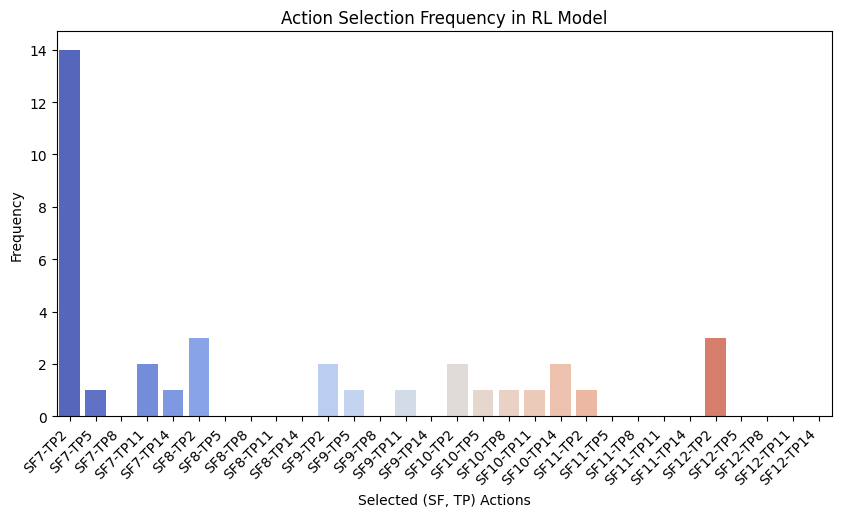

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each (SF, TP) action
action_counts = np.zeros(len(actions))

for state in Q:
    action_counts[np.argmax(Q[state])] += 1

sf_tp_labels = [f"SF{sf}-TP{tp}" for sf, tp in actions]

plt.figure(figsize=(10, 5))
sns.barplot(x=sf_tp_labels, y=action_counts, palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Selected (SF, TP) Actions")
plt.ylabel("Frequency")
plt.title("Action Selection Frequency in RL Model")
plt.show()


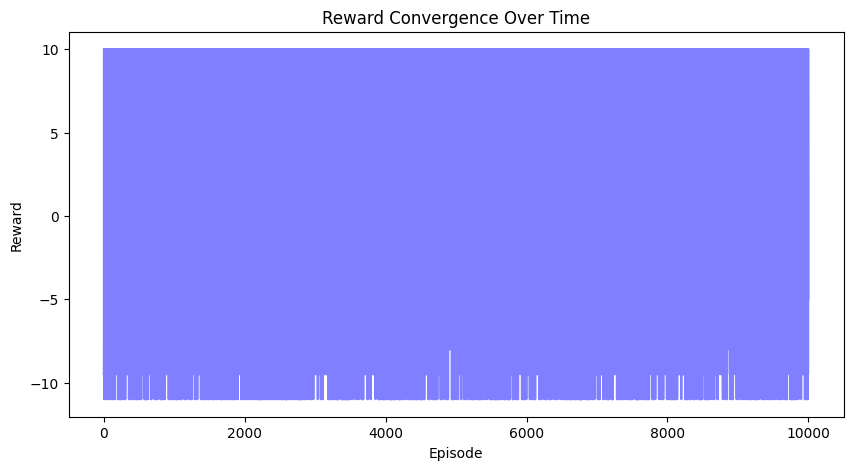

In [ ]:
rewards = []  # Store episode rewards

# Run RL training again while tracking rewards
for episode in range(10000):
    rssi = np.random.uniform(-120, -60)
    snr = np.random.uniform(-20, 10)
    state = get_state(rssi, snr)

    action_idx = choose_action(state)
    sf, tp = actions[action_idx]

    reward = get_reward(rssi, snr, sf, tp)
    rewards.append(reward)

    next_state = get_state(rssi, snr)
    next_max = np.max(Q[next_state])

    # Q-learning update
    Q[state][action_idx] = (1 - alpha) * Q[state][action_idx] + alpha * (reward + gamma * next_max)

# Plot reward over episodes
plt.figure(figsize=(10, 5))
plt.plot(rewards, color="blue", alpha=0.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Convergence Over Time")
plt.show()


RSSI = -110.68270849111387, SNR = -4.129554002687495
→ RL-selected SF = 9, TP = 11 dBm
RSSI = -111.82548855209814, SNR = -15.10617897712817
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -118.85084070543354, SNR = -3.926795601690049
→ RL-selected SF = 9, TP = 11 dBm
RSSI = -73.10240999632344, SNR = 3.431364430825095
→ RL-selected SF = 7, TP = 2 dBm
RSSI = -97.23627607402301, SNR = -17.488526351312938
→ RL-selected SF = 8, TP = 11 dBm
RSSI = -118.83049729439466, SNR = 3.5804399727254648
→ RL-selected SF = 10, TP = 2 dBm
RSSI = -111.46954870800946, SNR = -0.469657255406684
→ RL-selected SF = 9, TP = 11 dBm
RSSI = -73.54406424842276, SNR = -11.743385806292357
→ RL-selected SF = 8, TP = 11 dBm
RSSI = -83.12626302096737, SNR = -13.987858209749419
→ RL-selected SF = 7, TP = 11 dBm
RSSI = -108.71827698249399, SNR = -10.825268792133475
→ RL-selected SF = 9, TP = 5 dBm
RSSI = -73.8630649983222, SNR = 2.0290966932789374
→ RL-selected SF = 7, TP = 2 dBm
RSSI = -72.59512464280726, SNR = -7.514599461485

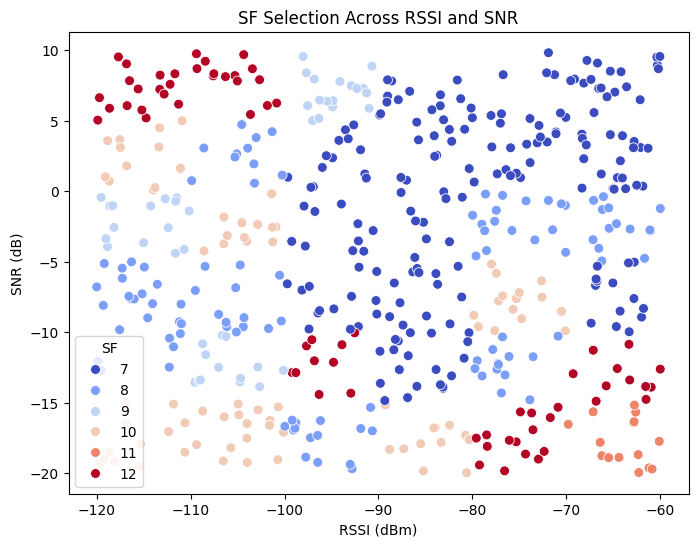

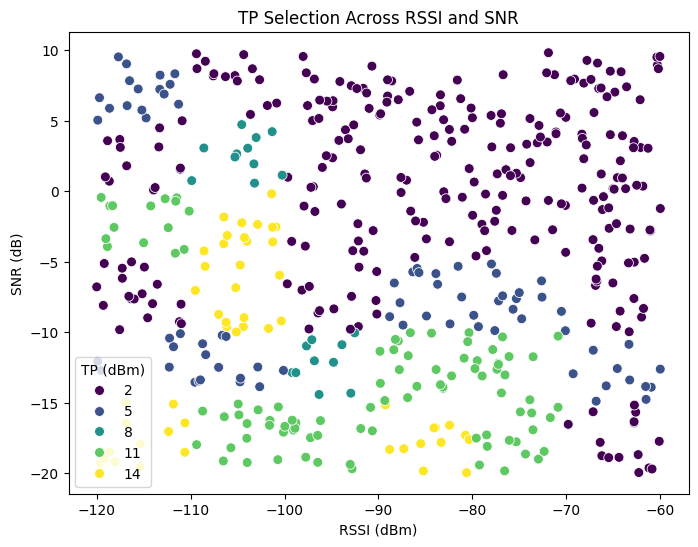

In [ ]:
import pandas as pd

# Generate test data
test_rssi = np.random.uniform(-120, -60, 500)
test_snr = np.random.uniform(-20, 10, 500)

sf_preds, tp_preds = zip(*[rl_predict(rssi, snr) for rssi, snr in zip(test_rssi, test_snr)])

df_results = pd.DataFrame({"RSSI": test_rssi, "SNR": test_snr, "SF": sf_preds, "TP": tp_preds})

# Scatter plot: RSSI vs. SNR with SF values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_results["RSSI"], y=df_results["SNR"], hue=df_results["SF"], palette="coolwarm", s=50)
plt.xlabel("RSSI (dBm)")
plt.ylabel("SNR (dB)")
plt.title("SF Selection Across RSSI and SNR")
plt.legend(title="SF")
plt.show()

# Scatter plot: RSSI vs. SNR with TP values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_results["RSSI"], y=df_results["SNR"], hue=df_results["TP"], palette="viridis", s=50)
plt.xlabel("RSSI (dBm)")
plt.ylabel("SNR (dB)")
plt.title("TP Selection Across RSSI and SNR")
plt.legend(title="TP (dBm)")
plt.show()


RSSI = -120.0, SNR = -20.0
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -120.0, SNR = -18.96551724137931
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -120.0, SNR = -17.93103448275862
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -120.0, SNR = -16.89655172413793
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -120.0, SNR = -15.862068965517242
→ RL-selected SF = 10, TP = 14 dBm
RSSI = -120.0, SNR = -14.827586206896552
→ RL-selected SF = 8, TP = 5 dBm
RSSI = -120.0, SNR = -13.793103448275861
→ RL-selected SF = 8, TP = 5 dBm
RSSI = -120.0, SNR = -12.75862068965517
→ RL-selected SF = 8, TP = 5 dBm
RSSI = -120.0, SNR = -11.724137931034482
→ RL-selected SF = 8, TP = 5 dBm
RSSI = -120.0, SNR = -10.689655172413792
→ RL-selected SF = 8, TP = 5 dBm
RSSI = -120.0, SNR = -9.655172413793103
→ RL-selected SF = 8, TP = 2 dBm
RSSI = -120.0, SNR = -8.620689655172413
→ RL-selected SF = 8, TP = 2 dBm
RSSI = -120.0, SNR = -7.586206896551722
→ RL-selected SF = 8, TP = 2 dBm
RSSI = -120.0, SNR = -6.551724137931034
→ RL-sele

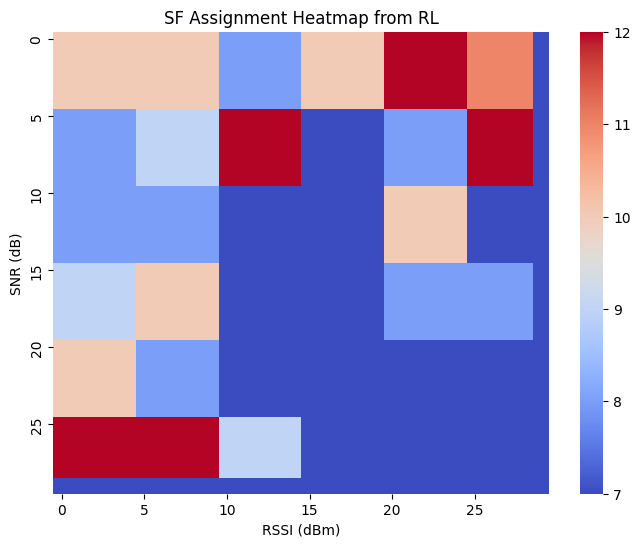

In [ ]:
import numpy as np

rssi_vals = np.linspace(-120, -60, 30)
snr_vals = np.linspace(-20, 10, 30)
heatmap_data = np.zeros((30, 30))

for i, rssi in enumerate(rssi_vals):
    for j, snr in enumerate(snr_vals):
        sf_pred, _ = rl_predict(rssi, snr)
        heatmap_data[j, i] = sf_pred

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, xticklabels=5, yticklabels=5, cmap="coolwarm", cbar=True)
plt.xlabel("RSSI (dBm)")
plt.ylabel("SNR (dB)")
plt.title("SF Assignment Heatmap from RL")
plt.show()
